In [1]:
import os, gzip, requests, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm

import jax, jax.numpy as jnp
import optax
from jax.random import PRNGKey


from restricted_boltzmann_machine.rbm import RBM
from restricted_boltzmann_machine.pcd_trainer import RBMTrainState, train_rbm
from restricted_boltzmann_machine.cosine_annealing_sampler import get_cosine_schedule

ModuleNotFoundError: No module named 'restricted_boltzmann_machine'

In [4]:
class MNISTTrainDataset:
    def __init__(self, root="./data"):
        self.save_dir = os.path.join(root, "MNIST", "raw")
        os.makedirs(self.save_dir, exist_ok=True)

        self.files = {
            "train_images": "train-images-idx3-ubyte.gz",
            "train_labels": "train-labels-idx1-ubyte.gz",
        }
        self.paths  = {k: os.path.join(self.save_dir, v)
                       for k, v in self.files.items()}
        self.base   = "https://storage.googleapis.com/cvdf-datasets/mnist/"
        self._download_if_needed()
        self.x = self._load_images(self.paths["train_images"])
        self.y = self._load_labels(self.paths["train_labels"])

    # ──── internals (unchanged) ────
    def _download_if_needed(self):
        for k, fname in self.files.items():
            p = self.paths[k]
            if os.path.exists(p):
                continue
            r = requests.get(self.base + fname, stream=True)
            if r.status_code != 200:
                raise RuntimeError(f"Download failed: {fname}")
            t = tqdm(total=int(r.headers.get("content-length", 0)),
                     desc=f"Downloading {fname}", unit="B", unit_scale=True)
            with open(p, "wb") as f:
                for chunk in r.iter_content(1024):
                    f.write(chunk); t.update(len(chunk))

    def _load_images(self, p):
        with gzip.open(p, "rb") as f:
            f.read(16)
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(-1, 28, 28)

    def _load_labels(self, p):
        with gzip.open(p, "rb") as f:
            f.read(8)
            return np.frombuffer(f.read(), dtype=np.uint8)

In [5]:
class BinarizedMNISTDataset:
    def __init__(self, raw):
        self.x = self._bin(raw.x)
        self.y = raw.y

    @staticmethod
    def _bin(x):
        x = (x.astype(np.float32) / 255.) > .5
        return jnp.array(x.reshape(x.shape[0], -1), dtype=jnp.float32)

    def __getitem__(self, idx): return self.x[idx], self.y[idx]
    def __len__(self):          return len(self.y)


class DataLoader:
    def __init__(self, dataset, batch_size=128,
                 shuffle=True, drop_last=False):
        self.x, self.y  = dataset.x, dataset.y
        self.bs         = batch_size
        self.shuffle    = shuffle
        self.drop_last  = drop_last
        self.idx_slices = [(i, i+batch_size)
                           for i in range(0, len(self.x), batch_size)
                           if not drop_last or i+batch_size <= len(self.x)]

    def __iter__(self):
        order = np.arange(len(self.x))
        if self.shuffle: np.random.shuffle(order)
        for s, e in self.idx_slices:
            sl = order[s:e]
            yield self.x[sl], self.y[sl]

    def __len__(self): return len(self.idx_slices)

In [6]:
def print_samples(samples, per_row=10, fig_w=10, cmap="binary"):
    n = len(samples)
    rows = (n + per_row - 1) // per_row
    plt.figure(figsize=(fig_w, fig_w/per_row*rows))
    for i, (lbl, img) in enumerate(samples):
        plt.subplot(rows, per_row, i+1)
        plt.imshow(img.squeeze(), cmap=cmap)
        plt.title(lbl); plt.axis("off")
    plt.tight_layout(); plt.show()

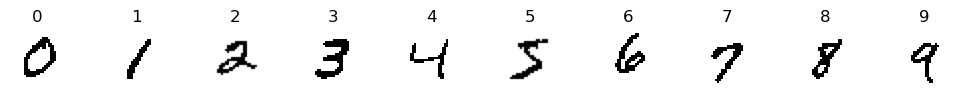

In [7]:
data_dir = "./data"
raw      = MNISTTrainDataset(root=data_dir)
train_ds = BinarizedMNISTDataset(raw)

demo = [(d, next(img.reshape(28,28) for img, l in train_ds if l == d))
        for d in range(10)]
print_samples(demo)

In [8]:
batch_size    = 128
n_vis         = 28*28
n_hid         = 256
k_steps       = 1
lr            = 1e-3
num_epochs    = 40
pcd_reset     = 75
weight_decay  = 1e-5
lr_decay      = 0.95

rng           = PRNGKey(0)
loader        = DataLoader(train_ds, batch_size, shuffle=True)

lr_sched      = optax.exponential_decay(lr, len(loader),
                                        decay_rate=lr_decay,
                                        staircase=True)
opt           = optax.adam(lr_sched)
rbm           = RBM(n_visible=n_vis, n_hidden=n_hid, k=k_steps)

dummy         = train_ds.x[:batch_size]
rng, sk       = jax.random.split(rng)
v_pers        = jax.random.bernoulli(sk, .5,
                                     shape=dummy.shape).astype(jnp.float32)
params        = rbm.init(rng, dummy, v_pers, rng)["params"]
state         = RBMTrainState.create(apply_fn=rbm.apply,
                                     params=params, tx=opt)


state, metrics, rng = train_rbm(state,
                                loader,
                                num_epochs,
                                rng,
                                pcd_reset=pcd_reset,
                                scheduler=lr_sched)

Epoch [1/40] – FE-loss: -80.7260
Epoch [2/40] – FE-loss: -147.6377
Epoch [3/40] – FE-loss: -229.3741
Epoch [4/40] – FE-loss: -211.5817
Epoch [5/40] – FE-loss: -195.3921
Epoch [6/40] – FE-loss: -162.6421
Epoch [7/40] – FE-loss: -126.9890
Epoch [8/40] – FE-loss: -99.3874
Epoch [9/40] – FE-loss: -83.4434
Epoch [10/40] – FE-loss: -72.2663
Epoch [11/40] – FE-loss: -67.2403
Epoch [12/40] – FE-loss: -70.3876
Epoch [13/40] – FE-loss: -63.6270
Epoch [14/40] – FE-loss: -64.1150
Epoch [15/40] – FE-loss: -62.1566
Epoch [16/40] – FE-loss: -58.0952
Epoch [17/40] – FE-loss: -53.8132
Epoch [18/40] – FE-loss: -53.0550
Epoch [19/40] – FE-loss: -51.4439
Epoch [20/40] – FE-loss: -50.1974
Epoch [21/40] – FE-loss: -51.0663
Epoch [22/40] – FE-loss: -47.2378
Epoch [23/40] – FE-loss: -47.5974
Epoch [24/40] – FE-loss: -43.6108
Epoch [25/40] – FE-loss: -42.3558
Epoch [26/40] – FE-loss: -40.1731
Epoch [27/40] – FE-loss: -40.9745
Epoch [28/40] – FE-loss: -40.5792
Epoch [29/40] – FE-loss: -40.8247
Epoch [30/40] – F

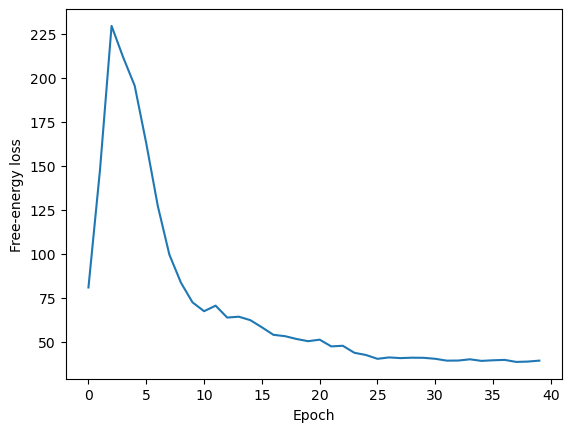

In [9]:
plt.plot([abs(metrics[e]['free_energy_loss']) for e in metrics])
plt.xlabel("Epoch"); plt.ylabel("Free-energy loss"); plt.show()

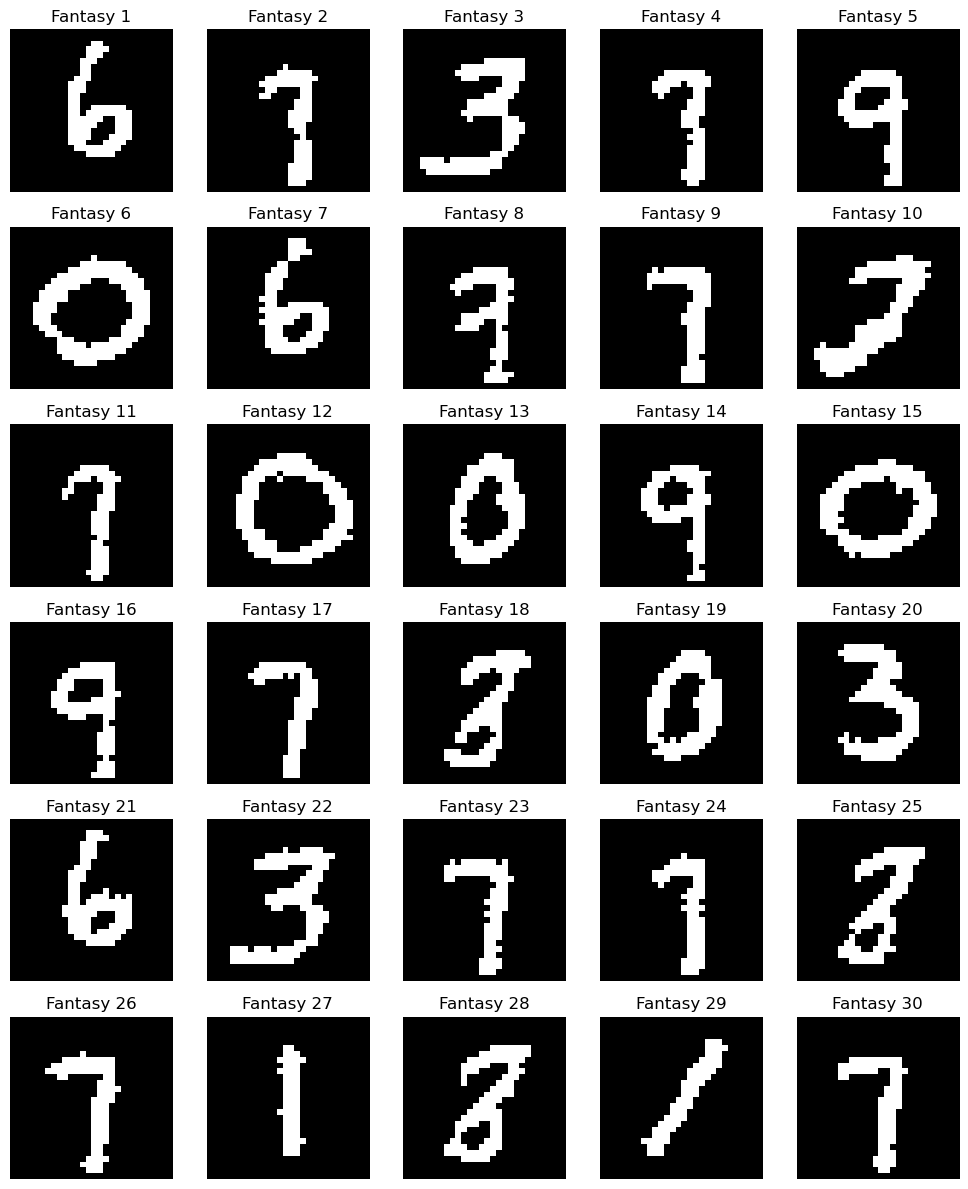

In [10]:
T_sched = get_cosine_schedule(4.0, .4, 1000)
samples = rbm.generate(params=state.params,
                       n_samples=30,
                       T_schedule=T_sched,
                       rng=rng).reshape(-1, 1, 28, 28)

labelled = [(f"Fantasy {i+1}", img) for i, img in enumerate(samples)]
print_samples(labelled, per_row=5, fig_w=10, cmap="gray")